In [1]:
%matplotlib inline

from graph_generator import grid_2d, add_p_and_delta
from utils import infeciton_time2weight
from plot_utils import plot_snapshot, add_colorbar
from ic import sample_graph_from_infection, make_partial_cascade
from joblib import Parallel, delayed
from collections import defaultdict
from tqdm import tqdm
from scipy.stats import hmean

In [2]:
g = grid_2d(10)
g = add_p_and_delta(g, p=0.7, d=1)

In [3]:
pos = {n: np.array(n) for n in g.nodes()}

In [4]:
def infection_time_estimation(g, n_rounds, mean_method='harmonic'):
    """
    estimate the harmonic mean of infection times given each node as source

    Returns:
    dict source to nodes' infection time:
    for each node as source, return the estimated infection times of all nodes
    """
    sampled_graphs = [sample_graph_from_infection(g)
                      for i in range(n_rounds)]
    s2t_len_list = Parallel(n_jobs=-1)(
        delayed(nx.shortest_path_length)(g, weight='d')
        for g in sampled_graphs)
    # 3D array
    s2n_times = defaultdict(lambda: defaultdict(list))

    for g, s2t_len in tqdm(zip(sampled_graphs, s2t_len_list)):
        for s in s2t_len:
            for n in g.nodes_iter():
                s2n_times[s][n].append(s2t_len[s].get(n, float('inf')))

    if mean_method == 'harmonic':
        def mean_func(times):
            times = np.array(times)
            times = times[np.nonzero(times)]
            if times.shape[0] >	0:
                return hmean(times)
            else:  # all zeros
                return 0
    elif mean_method == 'arithmetic':
        all_times = np.array([times
                              for n2times in s2n_times.values()
                              for times in n2times.values()])
        all_times = np.ravel(all_times)
        all_times = all_times[np.invert(np.isinf(all_times))]
        inf_value = all_times.max() + 1
        print(inf_value)

        def mean_func(times):
            times = np.array(times)
            times[np.isinf(times)] = inf_value
            return times.mean()

    else:
        raise ValueError('{"harmoic", "arithmetic"} accepted')

    est = defaultdict(dict)
    for s, n2times in tqdm(s2n_times.items()):
        for n, times in n2times.items():
            est[s][n] = mean_func(times)
    return est, s2n_times

100it [00:00, 120.09it/s]
 27%|██▋       | 27/100 [00:00<00:00, 265.44it/s]

30.0


100%|██████████| 100/100 [00:00<00:00, 258.73it/s]


6.15


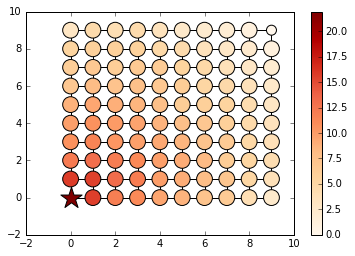

In [5]:
est, s2n_times = infection_time_estimation(g, 100, mean_method='arithmetic')
print(est[(0, 0)][(0, 1)])
weights = infeciton_time2weight(est[(0, 0)])
plot_snapshot(g, pos, weights, source_node=(0, 0))
add_colorbar(np.array(list(weights.values())))

In [6]:
print(est[(0, 0)][(0, 1)], est[(0, 0)][(0, 2)], est[(0, 0)][(1, 1)])

6.15 9.64 6.42


100it [00:00, 124.90it/s]
100%|██████████| 100/100 [00:00<00:00, 174.76it/s]


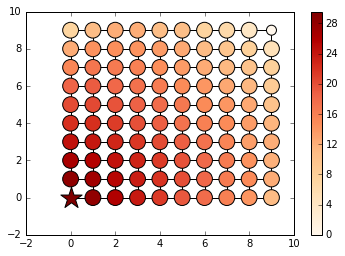

In [7]:
est, s2n_times = infection_time_estimation(g, 100, mean_method='harmonic')
weights = infeciton_time2weight(est[(0, 0)])
plot_snapshot(g, pos, weights, source_node=(0, 0))
add_colorbar(np.array(list(weights.values())))

In [8]:
print(est[(0, 0)][(0, 1)], est[(0, 0)][(0, 2)], est[(0, 0)][(1, 1)])

1.24985120819 3.09677419355 2.49221183801


In [9]:
source, obs_nodes, infection_times, _ = make_partial_cascade(g, 0.05, 'late_nodes')

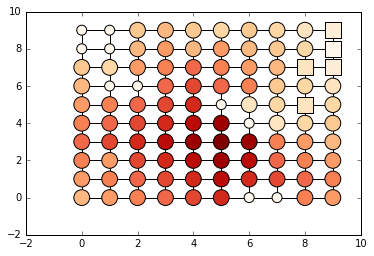

In [10]:
plot_snapshot(g, pos, infeciton_time2weight(infection_times), queried_nodes=obs_nodes)

In [13]:
hmean([float('inf'), 100])

200.0